<a href="https://colab.research.google.com/github/kausnz/ml_zoomcamp_homework/blob/main/ml_zoomcamp_wk4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4

In [11]:
%autosave 5

Autosaving every 5 seconds


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

We are basing Week4 on what we did during Week 3.

In [13]:
## Prep

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
    
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head().T

In [15]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and Dummy Model

* Evaluate the model on different thresholds
* Chceck the accurancy of dummy baselines

In [16]:
# Let's caculate the predication for the VALIDATION dataset. Just repeating what we did for the TEST data set two code cells ago.

dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val) # no need to fit here as we did a fit above. Can fit here if you like but won't make a difference.
y_val_pred = model.predict_proba(X_val)[:,1]
churn_decision_val = (y_val_pred >= 0.5)
(churn_decision_val == y_val).mean()

0.8034066713981547

In [17]:
threasholds = np.linspace(0, 1, 21)
scores = []

for t in threasholds:
    churn_decision_val = (y_val_pred >= t)
    mean = (churn_decision_val == y_val).mean()
    scores.append(mean)
    print("%.2f  %.3f" % (t, mean))
    

0.00  0.274
0.05  0.509
0.10  0.591
0.15  0.666
0.20  0.710
0.25  0.739
0.30  0.760
0.35  0.772
0.40  0.785
0.45  0.793
0.50  0.803
0.55  0.801
0.60  0.795
0.65  0.786
0.70  0.766
0.75  0.744
0.80  0.735
0.85  0.726
0.90  0.726
0.95  0.726
1.00  0.726


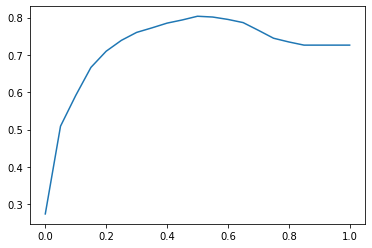

In [18]:
plt.plot(threasholds, scores)

In [19]:
# There's actually a function in sklearn called accuracy_score that we can use instead of calculating it using mean()
# Let's repeat what we did above using the sklearn's function.

from sklearn.metrics import accuracy_score

threasholds = np.linspace(0, 1, 21)
scores = []

for t in threasholds:
    churn_decision_val = (y_val_pred >= t)
    s = accuracy_score(y_val, churn_decision_val)
    scores.append(s)
    print("%.2f  %.3f" % (t, s))

0.00  0.274
0.05  0.509
0.10  0.591
0.15  0.666
0.20  0.710
0.25  0.739
0.30  0.760
0.35  0.772
0.40  0.785
0.45  0.793
0.50  0.803
0.55  0.801
0.60  0.795
0.65  0.786
0.70  0.766
0.75  0.744
0.80  0.735
0.85  0.726
0.90  0.726
0.95  0.726
1.00  0.726


What's interesting above is the accuracy for threshold 1.0 is 72.6%, compared to the real target values of the validation dataset. That means even if we consider the model prediction has to be 100% (P(X)= 1.0) for a customer to churn, the model accuracy is 72.6%. This is just 9% difference from the best accuracy we got (81.5 - 72,6).

In [20]:
# Quick query to remind us how many customers we have in int he val dataset
len(y_val)

1409

In [21]:
# then see how many did the model predicted as 1.0.
from collections import Counter
Counter(y_val_pred >= 1.0)

Counter({False: 1409})

Looks like none of the probability values were 1.0. So with 100% of the prediction probabilities says there are no customers churn, still the model gives a 72.6% accuracy. Hmmm!

Btw, the **Dummy Model** is the scenario the calculation is done based on threashold = 1.0.

In [22]:
# Check how many customers churned vs. didn't churn in the validation dataset.

Counter(y_val )


Counter({0: 1023, 1: 386})

In [23]:
1 - y_val.mean()  #gives 0.7260468417317246

# This is exactly what we get as the accurancy when threshold is 1.0.

0.7260468417317246

This means we have "class imbalance" in the dataset. This means there are more non-churn customers in the dataset than churned customers. In the validation dataset, the non-churn: churn ratio is 3:1
When there is a class imbalance, model 'accurancy' can be misleading. There are other better ways to evaluate models when the dataset has class imbalance.

## 4.3 Confusion Table
* Is a way of looking at different types corrent as well as incorrect decisions our binary classification model is making 
* Is a summarisation in tabular form

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t=0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

print(tp, tn, fp, fn)

210 922 101 176


In [25]:
# We can put this in a confision matrix using numpy as below.

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [26]:
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

Based on the values in the confusion matrix we can derive many more metrics such as Precision and Recall, and ROC Curves.

## 4.4 Precision and Recall

In [33]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

### Precision
Is the frequency of positive predictions that turned out to be correct, out of all the positive predictions.

In [34]:
(tp / (tp + fp)).round(2)

0.68

Out of all the positive predictions, we only got 68% ✅ of them correct. There are 32% ❌ incorrect predictions. 😞

### Recall 
Is the fraction of correctly predicted positives out of the total of actual positives.

In [35]:
(tp/ (tp + fn)).round(2)

0.54

Out of all the total actually positive observations, the model only predicted 54% ✅ of them as correct. That means it got 46% ❌ of the predictions incorrect.

Remember, accuracy of our model came our as 80% 🤡.

This shows us 'accuracy' is not a good metric at all when there's class imbalance in the data set. Precision and Recall are better metrcs to use in such situations as they can give us a better view of how good/bad the model is.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')